In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import sys 
sys.path.append('../')
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
%matplotlib inline

In [2]:
from wompth.models.dqn import Transition, ReplayMemory, DQN, ScreenDims, DQNConf, fit_networks

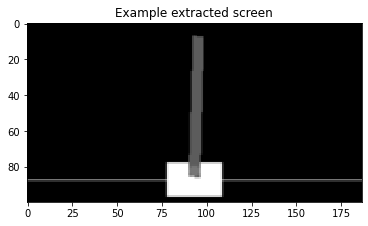

torch.Size([1, 100, 187])

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize(100),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.5)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
#     Strip off the edges, so that we have a square image centered on a cart

    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = 1- (np.ascontiguousarray(screen, dtype=np.float32) / 255)
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).numpy()[0],
           interpolation='none', cmap='gray')
plt.title('Example extracted screen')
plt.show()
get_screen().cpu().squeeze(0).shape

In [4]:

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
screen_dims = ScreenDims(screen_height, screen_width)


In [5]:
# nn.Sequential(
#     nn.Conv2d(3,32,kernel_size=3,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Flatten(),
#     nn.Linear(256*4*4,1024),
#     nn.ReLU(),
#     nn.Linear(1024,512),
#     nn.ReLU(),
#     nn.Linear(512,10))

In [6]:
# sequential = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2),
#       nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2),
#       nn.Flatten(start_dim=1)  ,
#       nn.Linear(in_features=15232, out_features=120),
#       nn.ReLU(),
# )

In [7]:
# sequential(get_screen())

In [8]:
get_screen().shape

torch.Size([1, 1, 100, 187])

In [9]:
from functools import partial
class DQN_BackBone_Simple(DQN): 
    def __init__(
        self,
        device="cuda",
        conf: DQNConf = DQNConf(),
        optimizer_partial=partial(optim.Adadelta),
        memory=ReplayMemory(10000),
        screen_dims=ScreenDims(height=40, width=150),
        outputs=2
    ):
        super().__init__(device, conf, optimizer_partial, memory, outputs)

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)        
        self.bn3 = nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 3, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(screen_dims.width)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(screen_dims.height)))
        linear_input_size = convw * convh * 128
        
        self.fc1 = nn.Linear(in_features=linear_input_size, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=self._outputs)

        self._send_to_device(device=device)

        
    def forward(self, x):
        x = x.to(self._device)
       
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.dropout(x, p=0.2, training=self.training)

        x = F.relu(self.fc1(x.view(x.size(0), -1)))

        return self.fc2(x)

        

In [10]:
from functools import partial
import torchvision.models as models

class DQN_BackBone_NET(DQN): 
    def __init__(
        self,
        device="cuda",
        conf: DQNConf = DQNConf(),
        optimizer_partial=partial(optim.Adadelta),
        memory=ReplayMemory(10000),
        screen_dims=ScreenDims(height=40, width=150),
        outputs=2
    ):
        super().__init__(device, conf, optimizer_partial, memory, outputs)
        
        self._net = models.resnet18(pretrained=False)
#         for idx, child in enumerate(self._net.children()):
#             if idx < 7: # Traning only the last sequential layers
#                 for param in child.parameters():
#                     param.requires_grad = False

        self._net.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, bias=False)
        self._net.fc = nn.Linear(in_features=512, out_features=self._outputs)

        self._send_to_device(device=device)

        
    def forward(self, x):
        x = x.to(self._device)
        return self._net(x)

        

In [11]:
conf = DQNConf(
    BATCH_SIZE = 32,
    GAMMA = .99,
    EPS_START = 0.10,
    TARGET_UPDATE = 10, 
    MAX_EPISODES = 1000,
)

In [12]:
DQN_Backbone_NET = partial(DQN_BackBone_Simple)

In [13]:
w, h= get_screen().shape[2:]
target_net = DQN_BackBone_NET(conf=conf, screen_dims=ScreenDims(height=h, width=w))
target_net

Using cuda device


DQN_BackBone_NET(
  (_net): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [14]:
target_net(get_screen())

/home/gorigan/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-0.4355, -0.7809]], device='cuda:0', grad_fn=<AddmmBackward>)

In [15]:

def moving_average_pth(x, w=10):
    kernel = [1/w] * w
    ts_tensor = torch.Tensor(x).reshape(1, 1, -1)
    kernel_tensor = torch.Tensor(kernel).reshape(1, 1, -1)
    return F.conv1d(ts_tensor, kernel_tensor).reshape(-1)

def plot_durations(i_episode, episode_durations):
    display.clear_output(wait=True)

    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel(f'Episode {i_episode}')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    means = moving_average_pth(durations_t, conf.TARGET_UPDATE)
    plt.plot(means.numpy())
    display.display(plt.gcf())


In [16]:

def reward_function_step(done, t, step_reward=10, max_reward=200):
    reward = 0
    
    step_bonus = ((t // step_reward)+1)**2
    
    if done:
        if t < max_reward: 
            reward = -500
        else: 
            reward = 0
            
    elif t >= step_reward // 2: 
        reward = step_bonus + t # promote the reward in steps 
    else: 
        reward = t

    return reward 
for t in range(0, 220, 10):
    print (t, reward_function_step(False, t), reward_function_step(True, t),) 

0 0 -500
10 14 -500
20 29 -500
30 46 -500
40 65 -500
50 86 -500
60 109 -500
70 134 -500
80 161 -500
90 190 -500
100 221 -500
110 254 -500
120 289 -500
130 326 -500
140 365 -500
150 406 -500
160 449 -500
170 494 -500
180 541 -500
190 590 -500
200 641 0
210 694 0


In [17]:
def reward_function_step2(done, t, step_reward=10, max_reward=200):
    
    reward = 0

    
    if done:
        if t < max_reward: 
            reward = -200
        else: 
            reward = max_reward
            
    else: 
        reward = step_reward
        

    return reward 
for t in range(0, 220, 10):
    print (t, t*10, reward_function_step2(False, t), reward_function_step2(True, t),) 

0 0 10 -200
10 100 10 -200
20 200 10 -200
30 300 10 -200
40 400 10 -200
50 500 10 -200
60 600 10 -200
70 700 10 -200
80 800 10 -200
90 900 10 -200
100 1000 10 -200
110 1100 10 -200
120 1200 10 -200
130 1300 10 -200
140 1400 10 -200
150 1500 10 -200
160 1600 10 -200
170 1700 10 -200
180 1800 10 -200
190 1900 10 -200
200 2000 10 200
210 2100 10 200


In [18]:
def reward_function_linear2(done, steps, max_reward=200):
    reward = 0

    if done:
        reward = -1
    else:
        reward = 10
        if steps > 100:
            reward += 10
        if steps > 200:
            reward += 10
        if steps > 300:
            reward += 10


    return reward 
for t in range(0, 220, 10):
    print (t, reward_function_linear2(False, t), reward_function_linear2(True, t),) 

0 10 -1
10 10 -1
20 10 -1
30 10 -1
40 10 -1
50 10 -1
60 10 -1
70 10 -1
80 10 -1
90 10 -1
100 10 -1
110 20 -1
120 20 -1
130 20 -1
140 20 -1
150 20 -1
160 20 -1
170 20 -1
180 20 -1
190 20 -1
200 20 -1
210 30 -1


In [19]:
episode_durations = []

In [20]:
# file_dict = torch.load('model_1455_avg_131.0.pth')
# target_net.load_state_dict(file_dict['state'])
# target_net._epsilon = 0

In [ ]:
num_episodes = conf.MAX_EPISODES
# restart policy net
policy_net = DQN_BackBone_NET(conf=conf, screen_dims=ScreenDims(height=h, width=w))
policy_net.load_states_from(target_net)
# policy_net._epsilon = 0.1
durations = fit_networks(policy_net, None, env, get_screen, 
                             num_episodes=num_episodes, 
                             episode_durations=episode_durations, 
                         reward_function=reward_function_linear2
                        )
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

Using cuda device


2021-10-17 03:04:48.981193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 03:04:48.981219: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
moving_average_pth(episode_durations[:1000], 2).max()

In [ ]:
str(conf)

In [ ]:
# file_dict = torch.load('model_1455_avg_131.0.pth')
# target_net.load_state_dict(file_dict['state'])
target_net._epsilon = 0

In [ ]:
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
for t in count():
    # Select and perform an action
    
    action = target_net.select_action(state)
    _, reward, done, _ = env.step(action.item())

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None
    
    state = next_state

    if done:
        episode_durations.append(t + 1)
        print(t)
        break